In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.utils.tensorboard import SummaryWriter






In [4]:
def create_curve(freq, ampl, freq_noise, ampl_noise, window_size):
    freq = random.gauss(freq, freq_noise) #add noise to frequency
    ampl = random.gauss(ampl, ampl_noise) #add noise to amplitude
    time = np.linspace(0, 10*np.pi, window_size)
    x = ampl*np.cos(freq*time)
    noise = np.random.normal(random.uniform(-1,0), random.uniform(0,1), window_size)
    x+=noise
    x = np.expand_dims(x, axis = 0) #expand to get 2d array (features, window length)
    x = np.expand_dims(x, axis = 0) #expand to get 3d array to store 2d elements
    #print(f"freq: {freq}, ampl:{ampl}")
    #plt.plot(time, x[0,0,:])
    #plt.show()
    
    return x

def create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size):
   
    X_data_class_1_domain_1 = np.empty((0,1,window_size))
    X_data_class_2_domain_1 = np.empty((0,1,window_size))
    X_data_class_1_domain_2 = np.empty((0,1,window_size))
    X_data_class_2_domain_2 = np.empty((0,1,window_size))
    
    for i in range(n):
        X_data_class_1_domain_1 = np.append(X_data_class_1_domain_1, create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size), axis = 0) 
        X_data_class_2_domain_1 = np.append(X_data_class_2_domain_1, create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_1_domain_2 = np.append(X_data_class_1_domain_2, create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_2_domain_2 = np.append(X_data_class_2_domain_2, create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size), axis = 0)
        print(f"Data loaded: {i+1}/{n}")
        #print(i)
        #print((X_data_class_1_domain_1))
        
    n_samples = np.shape(X_data_class_2_domain_1)[0]*2  
    
    y_data_class_1_domain_1 = np.asarray([0]*np.shape(X_data_class_1_domain_1)[0])
    y_data_class_2_domain_1 = np.asarray([1]*np.shape(X_data_class_2_domain_1)[0])
    y_data_class_1_domain_2 = np.asarray([0]*np.shape(X_data_class_1_domain_2)[0])
    y_data_class_2_domain_2 = np.asarray([1]*np.shape(X_data_class_2_domain_2)[0])
    
    X_data_source = np.concatenate((X_data_class_1_domain_1, X_data_class_2_domain_1), axis = 0)
    y_data_source = np.concatenate((y_data_class_1_domain_1, y_data_class_2_domain_1), axis = 0)
    X_data_target = np.concatenate((X_data_class_1_domain_2, X_data_class_2_domain_2), axis = 0)
    y_data_target = np.concatenate((y_data_class_1_domain_2, y_data_class_2_domain_2), axis = 0)
    
    
    X_data_source = torch.from_numpy(X_data_source)
    y_data_source = torch.from_numpy(y_data_source)
    X_data_target = torch.from_numpy(X_data_target)
    y_data_target = torch.from_numpy(y_data_target)
    
    return n_samples, X_data_source, y_data_source, X_data_target, y_data_target
"""
#TEST
frequencies = [1,4,1.4,3.6]
amplitudes = [6,2,5,4]
freq_noise = 0.3
ampl_noise = 2
window_size = 1000
n_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
"""

'\n#TEST\nfrequencies = [1,4,1.4,3.6]\namplitudes = [6,2,5,4]\nfreq_noise = 0.3\nampl_noise = 2\nwindow_size = 1000\nn_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)\n'

In [5]:
class Dataset_Dummy_Source_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,2,3]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, self.x_data, self.y_data, _, _ = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Dataset_Dummy_Target_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, _, _, self.x_data, self.y_data = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [6]:
#dataloader

dataset_source = Dataset_Dummy_Source_Window()

# define train/val dimensions
train_size_source = int(0.8 * len(dataset_source))
validation_size_source = len(dataset_source) - train_size_source

training_dataset_source, validation_dataset_source = torch.utils.data.random_split(dataset_source, [train_size_source, validation_size_source])
batch_size = 64
train_loader_source = DataLoader(dataset=training_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_source = DataLoader(dataset=validation_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)





dataset_target = Dataset_Dummy_Target_Window()

# define train/val dimensions
train_size_target = int(0.8 * len(dataset_target))
validation_size_target = len(dataset_target) - train_size_target

training_dataset_target, validation_dataset_target = torch.utils.data.random_split(dataset_target, [train_size_target, validation_size_target])
batch_size = 64
train_loader_target = DataLoader(dataset=training_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_target = DataLoader(dataset=validation_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

source_loader = {}
source_loader["train"] = train_loader_source
source_loader["val"] = validation_loader_source

target_loader = {}
target_loader["test"] = train_loader_target
target_loader["val"] = validation_loader_target

Data loaded: 1/8000
Data loaded: 2/8000
Data loaded: 3/8000
Data loaded: 4/8000
Data loaded: 5/8000
Data loaded: 6/8000
Data loaded: 7/8000
Data loaded: 8/8000
Data loaded: 9/8000
Data loaded: 10/8000
Data loaded: 11/8000
Data loaded: 12/8000
Data loaded: 13/8000
Data loaded: 14/8000
Data loaded: 15/8000
Data loaded: 16/8000
Data loaded: 17/8000
Data loaded: 18/8000
Data loaded: 19/8000
Data loaded: 20/8000
Data loaded: 21/8000
Data loaded: 22/8000
Data loaded: 23/8000
Data loaded: 24/8000
Data loaded: 25/8000
Data loaded: 26/8000
Data loaded: 27/8000
Data loaded: 28/8000
Data loaded: 29/8000
Data loaded: 30/8000
Data loaded: 31/8000
Data loaded: 32/8000
Data loaded: 33/8000
Data loaded: 34/8000
Data loaded: 35/8000
Data loaded: 36/8000
Data loaded: 37/8000
Data loaded: 38/8000
Data loaded: 39/8000
Data loaded: 40/8000
Data loaded: 41/8000
Data loaded: 42/8000
Data loaded: 43/8000
Data loaded: 44/8000
Data loaded: 45/8000
Data loaded: 46/8000
Data loaded: 47/8000
Data loaded: 48/8000
D

Data loaded: 387/8000
Data loaded: 388/8000
Data loaded: 389/8000
Data loaded: 390/8000
Data loaded: 391/8000
Data loaded: 392/8000
Data loaded: 393/8000
Data loaded: 394/8000
Data loaded: 395/8000
Data loaded: 396/8000
Data loaded: 397/8000
Data loaded: 398/8000
Data loaded: 399/8000
Data loaded: 400/8000
Data loaded: 401/8000
Data loaded: 402/8000
Data loaded: 403/8000
Data loaded: 404/8000
Data loaded: 405/8000
Data loaded: 406/8000
Data loaded: 407/8000
Data loaded: 408/8000
Data loaded: 409/8000
Data loaded: 410/8000
Data loaded: 411/8000
Data loaded: 412/8000
Data loaded: 413/8000
Data loaded: 414/8000
Data loaded: 415/8000
Data loaded: 416/8000
Data loaded: 417/8000
Data loaded: 418/8000
Data loaded: 419/8000
Data loaded: 420/8000
Data loaded: 421/8000
Data loaded: 422/8000
Data loaded: 423/8000
Data loaded: 424/8000
Data loaded: 425/8000
Data loaded: 426/8000
Data loaded: 427/8000
Data loaded: 428/8000
Data loaded: 429/8000
Data loaded: 430/8000
Data loaded: 431/8000
Data loade

Data loaded: 770/8000
Data loaded: 771/8000
Data loaded: 772/8000
Data loaded: 773/8000
Data loaded: 774/8000
Data loaded: 775/8000
Data loaded: 776/8000
Data loaded: 777/8000
Data loaded: 778/8000
Data loaded: 779/8000
Data loaded: 780/8000
Data loaded: 781/8000
Data loaded: 782/8000
Data loaded: 783/8000
Data loaded: 784/8000
Data loaded: 785/8000
Data loaded: 786/8000
Data loaded: 787/8000
Data loaded: 788/8000
Data loaded: 789/8000
Data loaded: 790/8000
Data loaded: 791/8000
Data loaded: 792/8000
Data loaded: 793/8000
Data loaded: 794/8000
Data loaded: 795/8000
Data loaded: 796/8000
Data loaded: 797/8000
Data loaded: 798/8000
Data loaded: 799/8000
Data loaded: 800/8000
Data loaded: 801/8000
Data loaded: 802/8000
Data loaded: 803/8000
Data loaded: 804/8000
Data loaded: 805/8000
Data loaded: 806/8000
Data loaded: 807/8000
Data loaded: 808/8000
Data loaded: 809/8000
Data loaded: 810/8000
Data loaded: 811/8000
Data loaded: 812/8000
Data loaded: 813/8000
Data loaded: 814/8000
Data loade

Data loaded: 1141/8000
Data loaded: 1142/8000
Data loaded: 1143/8000
Data loaded: 1144/8000
Data loaded: 1145/8000
Data loaded: 1146/8000
Data loaded: 1147/8000
Data loaded: 1148/8000
Data loaded: 1149/8000
Data loaded: 1150/8000
Data loaded: 1151/8000
Data loaded: 1152/8000
Data loaded: 1153/8000
Data loaded: 1154/8000
Data loaded: 1155/8000
Data loaded: 1156/8000
Data loaded: 1157/8000
Data loaded: 1158/8000
Data loaded: 1159/8000
Data loaded: 1160/8000
Data loaded: 1161/8000
Data loaded: 1162/8000
Data loaded: 1163/8000
Data loaded: 1164/8000
Data loaded: 1165/8000
Data loaded: 1166/8000
Data loaded: 1167/8000
Data loaded: 1168/8000
Data loaded: 1169/8000
Data loaded: 1170/8000
Data loaded: 1171/8000
Data loaded: 1172/8000
Data loaded: 1173/8000
Data loaded: 1174/8000
Data loaded: 1175/8000
Data loaded: 1176/8000
Data loaded: 1177/8000
Data loaded: 1178/8000
Data loaded: 1179/8000
Data loaded: 1180/8000
Data loaded: 1181/8000
Data loaded: 1182/8000
Data loaded: 1183/8000
Data loaded

Data loaded: 1499/8000
Data loaded: 1500/8000
Data loaded: 1501/8000
Data loaded: 1502/8000
Data loaded: 1503/8000
Data loaded: 1504/8000
Data loaded: 1505/8000
Data loaded: 1506/8000
Data loaded: 1507/8000
Data loaded: 1508/8000
Data loaded: 1509/8000
Data loaded: 1510/8000
Data loaded: 1511/8000
Data loaded: 1512/8000
Data loaded: 1513/8000
Data loaded: 1514/8000
Data loaded: 1515/8000
Data loaded: 1516/8000
Data loaded: 1517/8000
Data loaded: 1518/8000
Data loaded: 1519/8000
Data loaded: 1520/8000
Data loaded: 1521/8000
Data loaded: 1522/8000
Data loaded: 1523/8000
Data loaded: 1524/8000
Data loaded: 1525/8000
Data loaded: 1526/8000
Data loaded: 1527/8000
Data loaded: 1528/8000
Data loaded: 1529/8000
Data loaded: 1530/8000
Data loaded: 1531/8000
Data loaded: 1532/8000
Data loaded: 1533/8000
Data loaded: 1534/8000
Data loaded: 1535/8000
Data loaded: 1536/8000
Data loaded: 1537/8000
Data loaded: 1538/8000
Data loaded: 1539/8000
Data loaded: 1540/8000
Data loaded: 1541/8000
Data loaded

Data loaded: 1859/8000
Data loaded: 1860/8000
Data loaded: 1861/8000
Data loaded: 1862/8000
Data loaded: 1863/8000
Data loaded: 1864/8000
Data loaded: 1865/8000
Data loaded: 1866/8000
Data loaded: 1867/8000
Data loaded: 1868/8000
Data loaded: 1869/8000
Data loaded: 1870/8000
Data loaded: 1871/8000
Data loaded: 1872/8000
Data loaded: 1873/8000
Data loaded: 1874/8000
Data loaded: 1875/8000
Data loaded: 1876/8000
Data loaded: 1877/8000
Data loaded: 1878/8000
Data loaded: 1879/8000
Data loaded: 1880/8000
Data loaded: 1881/8000
Data loaded: 1882/8000
Data loaded: 1883/8000
Data loaded: 1884/8000
Data loaded: 1885/8000
Data loaded: 1886/8000
Data loaded: 1887/8000
Data loaded: 1888/8000
Data loaded: 1889/8000
Data loaded: 1890/8000
Data loaded: 1891/8000
Data loaded: 1892/8000
Data loaded: 1893/8000
Data loaded: 1894/8000
Data loaded: 1895/8000
Data loaded: 1896/8000
Data loaded: 1897/8000
Data loaded: 1898/8000
Data loaded: 1899/8000
Data loaded: 1900/8000
Data loaded: 1901/8000
Data loaded

Data loaded: 2220/8000
Data loaded: 2221/8000
Data loaded: 2222/8000
Data loaded: 2223/8000
Data loaded: 2224/8000
Data loaded: 2225/8000
Data loaded: 2226/8000
Data loaded: 2227/8000
Data loaded: 2228/8000
Data loaded: 2229/8000
Data loaded: 2230/8000
Data loaded: 2231/8000
Data loaded: 2232/8000
Data loaded: 2233/8000
Data loaded: 2234/8000
Data loaded: 2235/8000
Data loaded: 2236/8000
Data loaded: 2237/8000
Data loaded: 2238/8000
Data loaded: 2239/8000
Data loaded: 2240/8000
Data loaded: 2241/8000
Data loaded: 2242/8000
Data loaded: 2243/8000
Data loaded: 2244/8000
Data loaded: 2245/8000
Data loaded: 2246/8000
Data loaded: 2247/8000
Data loaded: 2248/8000
Data loaded: 2249/8000
Data loaded: 2250/8000
Data loaded: 2251/8000
Data loaded: 2252/8000
Data loaded: 2253/8000
Data loaded: 2254/8000
Data loaded: 2255/8000
Data loaded: 2256/8000
Data loaded: 2257/8000
Data loaded: 2258/8000
Data loaded: 2259/8000
Data loaded: 2260/8000
Data loaded: 2261/8000
Data loaded: 2262/8000
Data loaded

Data loaded: 2579/8000
Data loaded: 2580/8000
Data loaded: 2581/8000
Data loaded: 2582/8000
Data loaded: 2583/8000
Data loaded: 2584/8000
Data loaded: 2585/8000
Data loaded: 2586/8000
Data loaded: 2587/8000
Data loaded: 2588/8000
Data loaded: 2589/8000
Data loaded: 2590/8000
Data loaded: 2591/8000
Data loaded: 2592/8000
Data loaded: 2593/8000
Data loaded: 2594/8000
Data loaded: 2595/8000
Data loaded: 2596/8000
Data loaded: 2597/8000
Data loaded: 2598/8000
Data loaded: 2599/8000
Data loaded: 2600/8000
Data loaded: 2601/8000
Data loaded: 2602/8000
Data loaded: 2603/8000
Data loaded: 2604/8000
Data loaded: 2605/8000
Data loaded: 2606/8000
Data loaded: 2607/8000
Data loaded: 2608/8000
Data loaded: 2609/8000
Data loaded: 2610/8000
Data loaded: 2611/8000
Data loaded: 2612/8000
Data loaded: 2613/8000
Data loaded: 2614/8000
Data loaded: 2615/8000
Data loaded: 2616/8000
Data loaded: 2617/8000
Data loaded: 2618/8000
Data loaded: 2619/8000
Data loaded: 2620/8000
Data loaded: 2621/8000
Data loaded

Data loaded: 2937/8000
Data loaded: 2938/8000
Data loaded: 2939/8000
Data loaded: 2940/8000
Data loaded: 2941/8000
Data loaded: 2942/8000
Data loaded: 2943/8000
Data loaded: 2944/8000
Data loaded: 2945/8000
Data loaded: 2946/8000
Data loaded: 2947/8000
Data loaded: 2948/8000
Data loaded: 2949/8000
Data loaded: 2950/8000
Data loaded: 2951/8000
Data loaded: 2952/8000
Data loaded: 2953/8000
Data loaded: 2954/8000
Data loaded: 2955/8000
Data loaded: 2956/8000
Data loaded: 2957/8000
Data loaded: 2958/8000
Data loaded: 2959/8000
Data loaded: 2960/8000
Data loaded: 2961/8000
Data loaded: 2962/8000
Data loaded: 2963/8000
Data loaded: 2964/8000
Data loaded: 2965/8000
Data loaded: 2966/8000
Data loaded: 2967/8000
Data loaded: 2968/8000
Data loaded: 2969/8000
Data loaded: 2970/8000
Data loaded: 2971/8000
Data loaded: 2972/8000
Data loaded: 2973/8000
Data loaded: 2974/8000
Data loaded: 2975/8000
Data loaded: 2976/8000
Data loaded: 2977/8000
Data loaded: 2978/8000
Data loaded: 2979/8000
Data loaded

Data loaded: 3297/8000
Data loaded: 3298/8000
Data loaded: 3299/8000
Data loaded: 3300/8000
Data loaded: 3301/8000
Data loaded: 3302/8000
Data loaded: 3303/8000
Data loaded: 3304/8000
Data loaded: 3305/8000
Data loaded: 3306/8000
Data loaded: 3307/8000
Data loaded: 3308/8000
Data loaded: 3309/8000
Data loaded: 3310/8000
Data loaded: 3311/8000
Data loaded: 3312/8000
Data loaded: 3313/8000
Data loaded: 3314/8000
Data loaded: 3315/8000
Data loaded: 3316/8000
Data loaded: 3317/8000
Data loaded: 3318/8000
Data loaded: 3319/8000
Data loaded: 3320/8000
Data loaded: 3321/8000
Data loaded: 3322/8000
Data loaded: 3323/8000
Data loaded: 3324/8000
Data loaded: 3325/8000
Data loaded: 3326/8000
Data loaded: 3327/8000
Data loaded: 3328/8000
Data loaded: 3329/8000
Data loaded: 3330/8000
Data loaded: 3331/8000
Data loaded: 3332/8000
Data loaded: 3333/8000
Data loaded: 3334/8000
Data loaded: 3335/8000
Data loaded: 3336/8000
Data loaded: 3337/8000
Data loaded: 3338/8000
Data loaded: 3339/8000
Data loaded

Data loaded: 3656/8000
Data loaded: 3657/8000
Data loaded: 3658/8000
Data loaded: 3659/8000
Data loaded: 3660/8000
Data loaded: 3661/8000
Data loaded: 3662/8000
Data loaded: 3663/8000
Data loaded: 3664/8000
Data loaded: 3665/8000
Data loaded: 3666/8000
Data loaded: 3667/8000
Data loaded: 3668/8000
Data loaded: 3669/8000
Data loaded: 3670/8000
Data loaded: 3671/8000
Data loaded: 3672/8000
Data loaded: 3673/8000
Data loaded: 3674/8000
Data loaded: 3675/8000
Data loaded: 3676/8000
Data loaded: 3677/8000
Data loaded: 3678/8000
Data loaded: 3679/8000
Data loaded: 3680/8000
Data loaded: 3681/8000
Data loaded: 3682/8000
Data loaded: 3683/8000
Data loaded: 3684/8000
Data loaded: 3685/8000
Data loaded: 3686/8000
Data loaded: 3687/8000
Data loaded: 3688/8000
Data loaded: 3689/8000
Data loaded: 3690/8000
Data loaded: 3691/8000
Data loaded: 3692/8000
Data loaded: 3693/8000
Data loaded: 3694/8000
Data loaded: 3695/8000
Data loaded: 3696/8000
Data loaded: 3697/8000
Data loaded: 3698/8000
Data loaded

Data loaded: 4013/8000
Data loaded: 4014/8000
Data loaded: 4015/8000
Data loaded: 4016/8000
Data loaded: 4017/8000
Data loaded: 4018/8000
Data loaded: 4019/8000
Data loaded: 4020/8000
Data loaded: 4021/8000
Data loaded: 4022/8000
Data loaded: 4023/8000
Data loaded: 4024/8000
Data loaded: 4025/8000
Data loaded: 4026/8000
Data loaded: 4027/8000
Data loaded: 4028/8000
Data loaded: 4029/8000
Data loaded: 4030/8000
Data loaded: 4031/8000
Data loaded: 4032/8000
Data loaded: 4033/8000
Data loaded: 4034/8000
Data loaded: 4035/8000
Data loaded: 4036/8000
Data loaded: 4037/8000
Data loaded: 4038/8000
Data loaded: 4039/8000
Data loaded: 4040/8000
Data loaded: 4041/8000
Data loaded: 4042/8000
Data loaded: 4043/8000
Data loaded: 4044/8000
Data loaded: 4045/8000
Data loaded: 4046/8000
Data loaded: 4047/8000
Data loaded: 4048/8000
Data loaded: 4049/8000
Data loaded: 4050/8000
Data loaded: 4051/8000
Data loaded: 4052/8000
Data loaded: 4053/8000
Data loaded: 4054/8000
Data loaded: 4055/8000
Data loaded

Data loaded: 4370/8000
Data loaded: 4371/8000
Data loaded: 4372/8000
Data loaded: 4373/8000
Data loaded: 4374/8000
Data loaded: 4375/8000
Data loaded: 4376/8000
Data loaded: 4377/8000
Data loaded: 4378/8000
Data loaded: 4379/8000
Data loaded: 4380/8000
Data loaded: 4381/8000
Data loaded: 4382/8000
Data loaded: 4383/8000
Data loaded: 4384/8000
Data loaded: 4385/8000
Data loaded: 4386/8000
Data loaded: 4387/8000
Data loaded: 4388/8000
Data loaded: 4389/8000
Data loaded: 4390/8000
Data loaded: 4391/8000
Data loaded: 4392/8000
Data loaded: 4393/8000
Data loaded: 4394/8000
Data loaded: 4395/8000
Data loaded: 4396/8000
Data loaded: 4397/8000
Data loaded: 4398/8000
Data loaded: 4399/8000
Data loaded: 4400/8000
Data loaded: 4401/8000
Data loaded: 4402/8000
Data loaded: 4403/8000
Data loaded: 4404/8000
Data loaded: 4405/8000
Data loaded: 4406/8000
Data loaded: 4407/8000
Data loaded: 4408/8000
Data loaded: 4409/8000
Data loaded: 4410/8000
Data loaded: 4411/8000
Data loaded: 4412/8000
Data loaded

Data loaded: 4727/8000
Data loaded: 4728/8000
Data loaded: 4729/8000
Data loaded: 4730/8000
Data loaded: 4731/8000
Data loaded: 4732/8000
Data loaded: 4733/8000
Data loaded: 4734/8000
Data loaded: 4735/8000
Data loaded: 4736/8000
Data loaded: 4737/8000
Data loaded: 4738/8000
Data loaded: 4739/8000
Data loaded: 4740/8000
Data loaded: 4741/8000
Data loaded: 4742/8000
Data loaded: 4743/8000
Data loaded: 4744/8000
Data loaded: 4745/8000
Data loaded: 4746/8000
Data loaded: 4747/8000
Data loaded: 4748/8000
Data loaded: 4749/8000
Data loaded: 4750/8000
Data loaded: 4751/8000
Data loaded: 4752/8000
Data loaded: 4753/8000
Data loaded: 4754/8000
Data loaded: 4755/8000
Data loaded: 4756/8000
Data loaded: 4757/8000
Data loaded: 4758/8000
Data loaded: 4759/8000
Data loaded: 4760/8000
Data loaded: 4761/8000
Data loaded: 4762/8000
Data loaded: 4763/8000
Data loaded: 4764/8000
Data loaded: 4765/8000
Data loaded: 4766/8000
Data loaded: 4767/8000
Data loaded: 4768/8000
Data loaded: 4769/8000
Data loaded

Data loaded: 5084/8000
Data loaded: 5085/8000
Data loaded: 5086/8000
Data loaded: 5087/8000
Data loaded: 5088/8000
Data loaded: 5089/8000
Data loaded: 5090/8000
Data loaded: 5091/8000
Data loaded: 5092/8000
Data loaded: 5093/8000
Data loaded: 5094/8000
Data loaded: 5095/8000
Data loaded: 5096/8000
Data loaded: 5097/8000
Data loaded: 5098/8000
Data loaded: 5099/8000
Data loaded: 5100/8000
Data loaded: 5101/8000
Data loaded: 5102/8000
Data loaded: 5103/8000
Data loaded: 5104/8000
Data loaded: 5105/8000
Data loaded: 5106/8000
Data loaded: 5107/8000
Data loaded: 5108/8000
Data loaded: 5109/8000
Data loaded: 5110/8000
Data loaded: 5111/8000
Data loaded: 5112/8000
Data loaded: 5113/8000
Data loaded: 5114/8000
Data loaded: 5115/8000
Data loaded: 5116/8000
Data loaded: 5117/8000
Data loaded: 5118/8000
Data loaded: 5119/8000
Data loaded: 5120/8000
Data loaded: 5121/8000
Data loaded: 5122/8000
Data loaded: 5123/8000
Data loaded: 5124/8000
Data loaded: 5125/8000
Data loaded: 5126/8000
Data loaded

Data loaded: 5442/8000
Data loaded: 5443/8000
Data loaded: 5444/8000
Data loaded: 5445/8000
Data loaded: 5446/8000
Data loaded: 5447/8000
Data loaded: 5448/8000
Data loaded: 5449/8000
Data loaded: 5450/8000
Data loaded: 5451/8000
Data loaded: 5452/8000
Data loaded: 5453/8000
Data loaded: 5454/8000
Data loaded: 5455/8000
Data loaded: 5456/8000
Data loaded: 5457/8000
Data loaded: 5458/8000
Data loaded: 5459/8000
Data loaded: 5460/8000
Data loaded: 5461/8000
Data loaded: 5462/8000
Data loaded: 5463/8000
Data loaded: 5464/8000
Data loaded: 5465/8000
Data loaded: 5466/8000
Data loaded: 5467/8000
Data loaded: 5468/8000
Data loaded: 5469/8000
Data loaded: 5470/8000
Data loaded: 5471/8000
Data loaded: 5472/8000
Data loaded: 5473/8000
Data loaded: 5474/8000
Data loaded: 5475/8000
Data loaded: 5476/8000
Data loaded: 5477/8000
Data loaded: 5478/8000
Data loaded: 5479/8000
Data loaded: 5480/8000
Data loaded: 5481/8000
Data loaded: 5482/8000
Data loaded: 5483/8000
Data loaded: 5484/8000
Data loaded

Data loaded: 5800/8000
Data loaded: 5801/8000
Data loaded: 5802/8000
Data loaded: 5803/8000
Data loaded: 5804/8000
Data loaded: 5805/8000
Data loaded: 5806/8000
Data loaded: 5807/8000
Data loaded: 5808/8000
Data loaded: 5809/8000
Data loaded: 5810/8000
Data loaded: 5811/8000
Data loaded: 5812/8000
Data loaded: 5813/8000
Data loaded: 5814/8000
Data loaded: 5815/8000
Data loaded: 5816/8000
Data loaded: 5817/8000
Data loaded: 5818/8000
Data loaded: 5819/8000
Data loaded: 5820/8000
Data loaded: 5821/8000
Data loaded: 5822/8000
Data loaded: 5823/8000
Data loaded: 5824/8000
Data loaded: 5825/8000
Data loaded: 5826/8000
Data loaded: 5827/8000
Data loaded: 5828/8000
Data loaded: 5829/8000
Data loaded: 5830/8000
Data loaded: 5831/8000
Data loaded: 5832/8000
Data loaded: 5833/8000
Data loaded: 5834/8000
Data loaded: 5835/8000
Data loaded: 5836/8000
Data loaded: 5837/8000
Data loaded: 5838/8000
Data loaded: 5839/8000
Data loaded: 5840/8000
Data loaded: 5841/8000
Data loaded: 5842/8000
Data loaded

Data loaded: 6158/8000
Data loaded: 6159/8000
Data loaded: 6160/8000
Data loaded: 6161/8000
Data loaded: 6162/8000
Data loaded: 6163/8000
Data loaded: 6164/8000
Data loaded: 6165/8000
Data loaded: 6166/8000
Data loaded: 6167/8000
Data loaded: 6168/8000
Data loaded: 6169/8000
Data loaded: 6170/8000
Data loaded: 6171/8000
Data loaded: 6172/8000
Data loaded: 6173/8000
Data loaded: 6174/8000
Data loaded: 6175/8000
Data loaded: 6176/8000
Data loaded: 6177/8000
Data loaded: 6178/8000
Data loaded: 6179/8000
Data loaded: 6180/8000
Data loaded: 6181/8000
Data loaded: 6182/8000
Data loaded: 6183/8000
Data loaded: 6184/8000
Data loaded: 6185/8000
Data loaded: 6186/8000
Data loaded: 6187/8000
Data loaded: 6188/8000
Data loaded: 6189/8000
Data loaded: 6190/8000
Data loaded: 6191/8000
Data loaded: 6192/8000
Data loaded: 6193/8000
Data loaded: 6194/8000
Data loaded: 6195/8000
Data loaded: 6196/8000
Data loaded: 6197/8000
Data loaded: 6198/8000
Data loaded: 6199/8000
Data loaded: 6200/8000
Data loaded

Data loaded: 6516/8000
Data loaded: 6517/8000
Data loaded: 6518/8000
Data loaded: 6519/8000
Data loaded: 6520/8000
Data loaded: 6521/8000
Data loaded: 6522/8000
Data loaded: 6523/8000
Data loaded: 6524/8000
Data loaded: 6525/8000
Data loaded: 6526/8000
Data loaded: 6527/8000
Data loaded: 6528/8000
Data loaded: 6529/8000
Data loaded: 6530/8000
Data loaded: 6531/8000
Data loaded: 6532/8000
Data loaded: 6533/8000
Data loaded: 6534/8000
Data loaded: 6535/8000
Data loaded: 6536/8000
Data loaded: 6537/8000
Data loaded: 6538/8000
Data loaded: 6539/8000
Data loaded: 6540/8000
Data loaded: 6541/8000
Data loaded: 6542/8000
Data loaded: 6543/8000
Data loaded: 6544/8000
Data loaded: 6545/8000
Data loaded: 6546/8000
Data loaded: 6547/8000
Data loaded: 6548/8000
Data loaded: 6549/8000
Data loaded: 6550/8000
Data loaded: 6551/8000
Data loaded: 6552/8000
Data loaded: 6553/8000
Data loaded: 6554/8000
Data loaded: 6555/8000
Data loaded: 6556/8000
Data loaded: 6557/8000
Data loaded: 6558/8000
Data loaded

Data loaded: 6873/8000
Data loaded: 6874/8000
Data loaded: 6875/8000
Data loaded: 6876/8000
Data loaded: 6877/8000
Data loaded: 6878/8000
Data loaded: 6879/8000
Data loaded: 6880/8000
Data loaded: 6881/8000
Data loaded: 6882/8000
Data loaded: 6883/8000
Data loaded: 6884/8000
Data loaded: 6885/8000
Data loaded: 6886/8000
Data loaded: 6887/8000
Data loaded: 6888/8000
Data loaded: 6889/8000
Data loaded: 6890/8000
Data loaded: 6891/8000
Data loaded: 6892/8000
Data loaded: 6893/8000
Data loaded: 6894/8000
Data loaded: 6895/8000
Data loaded: 6896/8000
Data loaded: 6897/8000
Data loaded: 6898/8000
Data loaded: 6899/8000
Data loaded: 6900/8000
Data loaded: 6901/8000
Data loaded: 6902/8000
Data loaded: 6903/8000
Data loaded: 6904/8000
Data loaded: 6905/8000
Data loaded: 6906/8000
Data loaded: 6907/8000
Data loaded: 6908/8000
Data loaded: 6909/8000
Data loaded: 6910/8000
Data loaded: 6911/8000
Data loaded: 6912/8000
Data loaded: 6913/8000
Data loaded: 6914/8000
Data loaded: 6915/8000
Data loaded

Data loaded: 7230/8000
Data loaded: 7231/8000
Data loaded: 7232/8000
Data loaded: 7233/8000
Data loaded: 7234/8000
Data loaded: 7235/8000
Data loaded: 7236/8000
Data loaded: 7237/8000
Data loaded: 7238/8000
Data loaded: 7239/8000
Data loaded: 7240/8000
Data loaded: 7241/8000
Data loaded: 7242/8000
Data loaded: 7243/8000
Data loaded: 7244/8000
Data loaded: 7245/8000
Data loaded: 7246/8000
Data loaded: 7247/8000
Data loaded: 7248/8000
Data loaded: 7249/8000
Data loaded: 7250/8000
Data loaded: 7251/8000
Data loaded: 7252/8000
Data loaded: 7253/8000
Data loaded: 7254/8000
Data loaded: 7255/8000
Data loaded: 7256/8000
Data loaded: 7257/8000
Data loaded: 7258/8000
Data loaded: 7259/8000
Data loaded: 7260/8000
Data loaded: 7261/8000
Data loaded: 7262/8000
Data loaded: 7263/8000
Data loaded: 7264/8000
Data loaded: 7265/8000
Data loaded: 7266/8000
Data loaded: 7267/8000
Data loaded: 7268/8000
Data loaded: 7269/8000
Data loaded: 7270/8000
Data loaded: 7271/8000
Data loaded: 7272/8000
Data loaded

Data loaded: 7587/8000
Data loaded: 7588/8000
Data loaded: 7589/8000
Data loaded: 7590/8000
Data loaded: 7591/8000
Data loaded: 7592/8000
Data loaded: 7593/8000
Data loaded: 7594/8000
Data loaded: 7595/8000
Data loaded: 7596/8000
Data loaded: 7597/8000
Data loaded: 7598/8000
Data loaded: 7599/8000
Data loaded: 7600/8000
Data loaded: 7601/8000
Data loaded: 7602/8000
Data loaded: 7603/8000
Data loaded: 7604/8000
Data loaded: 7605/8000
Data loaded: 7606/8000
Data loaded: 7607/8000
Data loaded: 7608/8000
Data loaded: 7609/8000
Data loaded: 7610/8000
Data loaded: 7611/8000
Data loaded: 7612/8000
Data loaded: 7613/8000
Data loaded: 7614/8000
Data loaded: 7615/8000
Data loaded: 7616/8000
Data loaded: 7617/8000
Data loaded: 7618/8000
Data loaded: 7619/8000
Data loaded: 7620/8000
Data loaded: 7621/8000
Data loaded: 7622/8000
Data loaded: 7623/8000
Data loaded: 7624/8000
Data loaded: 7625/8000
Data loaded: 7626/8000
Data loaded: 7627/8000
Data loaded: 7628/8000
Data loaded: 7629/8000
Data loaded

Data loaded: 7944/8000
Data loaded: 7945/8000
Data loaded: 7946/8000
Data loaded: 7947/8000
Data loaded: 7948/8000
Data loaded: 7949/8000
Data loaded: 7950/8000
Data loaded: 7951/8000
Data loaded: 7952/8000
Data loaded: 7953/8000
Data loaded: 7954/8000
Data loaded: 7955/8000
Data loaded: 7956/8000
Data loaded: 7957/8000
Data loaded: 7958/8000
Data loaded: 7959/8000
Data loaded: 7960/8000
Data loaded: 7961/8000
Data loaded: 7962/8000
Data loaded: 7963/8000
Data loaded: 7964/8000
Data loaded: 7965/8000
Data loaded: 7966/8000
Data loaded: 7967/8000
Data loaded: 7968/8000
Data loaded: 7969/8000
Data loaded: 7970/8000
Data loaded: 7971/8000
Data loaded: 7972/8000
Data loaded: 7973/8000
Data loaded: 7974/8000
Data loaded: 7975/8000
Data loaded: 7976/8000
Data loaded: 7977/8000
Data loaded: 7978/8000
Data loaded: 7979/8000
Data loaded: 7980/8000
Data loaded: 7981/8000
Data loaded: 7982/8000
Data loaded: 7983/8000
Data loaded: 7984/8000
Data loaded: 7985/8000
Data loaded: 7986/8000
Data loaded

Data loaded: 339/8000
Data loaded: 340/8000
Data loaded: 341/8000
Data loaded: 342/8000
Data loaded: 343/8000
Data loaded: 344/8000
Data loaded: 345/8000
Data loaded: 346/8000
Data loaded: 347/8000
Data loaded: 348/8000
Data loaded: 349/8000
Data loaded: 350/8000
Data loaded: 351/8000
Data loaded: 352/8000
Data loaded: 353/8000
Data loaded: 354/8000
Data loaded: 355/8000
Data loaded: 356/8000
Data loaded: 357/8000
Data loaded: 358/8000
Data loaded: 359/8000
Data loaded: 360/8000
Data loaded: 361/8000
Data loaded: 362/8000
Data loaded: 363/8000
Data loaded: 364/8000
Data loaded: 365/8000
Data loaded: 366/8000
Data loaded: 367/8000
Data loaded: 368/8000
Data loaded: 369/8000
Data loaded: 370/8000
Data loaded: 371/8000
Data loaded: 372/8000
Data loaded: 373/8000
Data loaded: 374/8000
Data loaded: 375/8000
Data loaded: 376/8000
Data loaded: 377/8000
Data loaded: 378/8000
Data loaded: 379/8000
Data loaded: 380/8000
Data loaded: 381/8000
Data loaded: 382/8000
Data loaded: 383/8000
Data loade

Data loaded: 724/8000
Data loaded: 725/8000
Data loaded: 726/8000
Data loaded: 727/8000
Data loaded: 728/8000
Data loaded: 729/8000
Data loaded: 730/8000
Data loaded: 731/8000
Data loaded: 732/8000
Data loaded: 733/8000
Data loaded: 734/8000
Data loaded: 735/8000
Data loaded: 736/8000
Data loaded: 737/8000
Data loaded: 738/8000
Data loaded: 739/8000
Data loaded: 740/8000
Data loaded: 741/8000
Data loaded: 742/8000
Data loaded: 743/8000
Data loaded: 744/8000
Data loaded: 745/8000
Data loaded: 746/8000
Data loaded: 747/8000
Data loaded: 748/8000
Data loaded: 749/8000
Data loaded: 750/8000
Data loaded: 751/8000
Data loaded: 752/8000
Data loaded: 753/8000
Data loaded: 754/8000
Data loaded: 755/8000
Data loaded: 756/8000
Data loaded: 757/8000
Data loaded: 758/8000
Data loaded: 759/8000
Data loaded: 760/8000
Data loaded: 761/8000
Data loaded: 762/8000
Data loaded: 763/8000
Data loaded: 764/8000
Data loaded: 765/8000
Data loaded: 766/8000
Data loaded: 767/8000
Data loaded: 768/8000
Data loade

Data loaded: 1097/8000
Data loaded: 1098/8000
Data loaded: 1099/8000
Data loaded: 1100/8000
Data loaded: 1101/8000
Data loaded: 1102/8000
Data loaded: 1103/8000
Data loaded: 1104/8000
Data loaded: 1105/8000
Data loaded: 1106/8000
Data loaded: 1107/8000
Data loaded: 1108/8000
Data loaded: 1109/8000
Data loaded: 1110/8000
Data loaded: 1111/8000
Data loaded: 1112/8000
Data loaded: 1113/8000
Data loaded: 1114/8000
Data loaded: 1115/8000
Data loaded: 1116/8000
Data loaded: 1117/8000
Data loaded: 1118/8000
Data loaded: 1119/8000
Data loaded: 1120/8000
Data loaded: 1121/8000
Data loaded: 1122/8000
Data loaded: 1123/8000
Data loaded: 1124/8000
Data loaded: 1125/8000
Data loaded: 1126/8000
Data loaded: 1127/8000
Data loaded: 1128/8000
Data loaded: 1129/8000
Data loaded: 1130/8000
Data loaded: 1131/8000
Data loaded: 1132/8000
Data loaded: 1133/8000
Data loaded: 1134/8000
Data loaded: 1135/8000
Data loaded: 1136/8000
Data loaded: 1137/8000
Data loaded: 1138/8000
Data loaded: 1139/8000
Data loaded

Data loaded: 1459/8000
Data loaded: 1460/8000
Data loaded: 1461/8000
Data loaded: 1462/8000
Data loaded: 1463/8000
Data loaded: 1464/8000
Data loaded: 1465/8000
Data loaded: 1466/8000
Data loaded: 1467/8000
Data loaded: 1468/8000
Data loaded: 1469/8000
Data loaded: 1470/8000
Data loaded: 1471/8000
Data loaded: 1472/8000
Data loaded: 1473/8000
Data loaded: 1474/8000
Data loaded: 1475/8000
Data loaded: 1476/8000
Data loaded: 1477/8000
Data loaded: 1478/8000
Data loaded: 1479/8000
Data loaded: 1480/8000
Data loaded: 1481/8000
Data loaded: 1482/8000
Data loaded: 1483/8000
Data loaded: 1484/8000
Data loaded: 1485/8000
Data loaded: 1486/8000
Data loaded: 1487/8000
Data loaded: 1488/8000
Data loaded: 1489/8000
Data loaded: 1490/8000
Data loaded: 1491/8000
Data loaded: 1492/8000
Data loaded: 1493/8000
Data loaded: 1494/8000
Data loaded: 1495/8000
Data loaded: 1496/8000
Data loaded: 1497/8000
Data loaded: 1498/8000
Data loaded: 1499/8000
Data loaded: 1500/8000
Data loaded: 1501/8000
Data loaded

Data loaded: 1821/8000
Data loaded: 1822/8000
Data loaded: 1823/8000
Data loaded: 1824/8000
Data loaded: 1825/8000
Data loaded: 1826/8000
Data loaded: 1827/8000
Data loaded: 1828/8000
Data loaded: 1829/8000
Data loaded: 1830/8000
Data loaded: 1831/8000
Data loaded: 1832/8000
Data loaded: 1833/8000
Data loaded: 1834/8000
Data loaded: 1835/8000
Data loaded: 1836/8000
Data loaded: 1837/8000
Data loaded: 1838/8000
Data loaded: 1839/8000
Data loaded: 1840/8000
Data loaded: 1841/8000
Data loaded: 1842/8000
Data loaded: 1843/8000
Data loaded: 1844/8000
Data loaded: 1845/8000
Data loaded: 1846/8000
Data loaded: 1847/8000
Data loaded: 1848/8000
Data loaded: 1849/8000
Data loaded: 1850/8000
Data loaded: 1851/8000
Data loaded: 1852/8000
Data loaded: 1853/8000
Data loaded: 1854/8000
Data loaded: 1855/8000
Data loaded: 1856/8000
Data loaded: 1857/8000
Data loaded: 1858/8000
Data loaded: 1859/8000
Data loaded: 1860/8000
Data loaded: 1861/8000
Data loaded: 1862/8000
Data loaded: 1863/8000
Data loaded

Data loaded: 2179/8000
Data loaded: 2180/8000
Data loaded: 2181/8000
Data loaded: 2182/8000
Data loaded: 2183/8000
Data loaded: 2184/8000
Data loaded: 2185/8000
Data loaded: 2186/8000
Data loaded: 2187/8000
Data loaded: 2188/8000
Data loaded: 2189/8000
Data loaded: 2190/8000
Data loaded: 2191/8000
Data loaded: 2192/8000
Data loaded: 2193/8000
Data loaded: 2194/8000
Data loaded: 2195/8000
Data loaded: 2196/8000
Data loaded: 2197/8000
Data loaded: 2198/8000
Data loaded: 2199/8000
Data loaded: 2200/8000
Data loaded: 2201/8000
Data loaded: 2202/8000
Data loaded: 2203/8000
Data loaded: 2204/8000
Data loaded: 2205/8000
Data loaded: 2206/8000
Data loaded: 2207/8000
Data loaded: 2208/8000
Data loaded: 2209/8000
Data loaded: 2210/8000
Data loaded: 2211/8000
Data loaded: 2212/8000
Data loaded: 2213/8000
Data loaded: 2214/8000
Data loaded: 2215/8000
Data loaded: 2216/8000
Data loaded: 2217/8000
Data loaded: 2218/8000
Data loaded: 2219/8000
Data loaded: 2220/8000
Data loaded: 2221/8000
Data loaded

Data loaded: 2537/8000
Data loaded: 2538/8000
Data loaded: 2539/8000
Data loaded: 2540/8000
Data loaded: 2541/8000
Data loaded: 2542/8000
Data loaded: 2543/8000
Data loaded: 2544/8000
Data loaded: 2545/8000
Data loaded: 2546/8000
Data loaded: 2547/8000
Data loaded: 2548/8000
Data loaded: 2549/8000
Data loaded: 2550/8000
Data loaded: 2551/8000
Data loaded: 2552/8000
Data loaded: 2553/8000
Data loaded: 2554/8000
Data loaded: 2555/8000
Data loaded: 2556/8000
Data loaded: 2557/8000
Data loaded: 2558/8000
Data loaded: 2559/8000
Data loaded: 2560/8000
Data loaded: 2561/8000
Data loaded: 2562/8000
Data loaded: 2563/8000
Data loaded: 2564/8000
Data loaded: 2565/8000
Data loaded: 2566/8000
Data loaded: 2567/8000
Data loaded: 2568/8000
Data loaded: 2569/8000
Data loaded: 2570/8000
Data loaded: 2571/8000
Data loaded: 2572/8000
Data loaded: 2573/8000
Data loaded: 2574/8000
Data loaded: 2575/8000
Data loaded: 2576/8000
Data loaded: 2577/8000
Data loaded: 2578/8000
Data loaded: 2579/8000
Data loaded

Data loaded: 2896/8000
Data loaded: 2897/8000
Data loaded: 2898/8000
Data loaded: 2899/8000
Data loaded: 2900/8000
Data loaded: 2901/8000
Data loaded: 2902/8000
Data loaded: 2903/8000
Data loaded: 2904/8000
Data loaded: 2905/8000
Data loaded: 2906/8000
Data loaded: 2907/8000
Data loaded: 2908/8000
Data loaded: 2909/8000
Data loaded: 2910/8000
Data loaded: 2911/8000
Data loaded: 2912/8000
Data loaded: 2913/8000
Data loaded: 2914/8000
Data loaded: 2915/8000
Data loaded: 2916/8000
Data loaded: 2917/8000
Data loaded: 2918/8000
Data loaded: 2919/8000
Data loaded: 2920/8000
Data loaded: 2921/8000
Data loaded: 2922/8000
Data loaded: 2923/8000
Data loaded: 2924/8000
Data loaded: 2925/8000
Data loaded: 2926/8000
Data loaded: 2927/8000
Data loaded: 2928/8000
Data loaded: 2929/8000
Data loaded: 2930/8000
Data loaded: 2931/8000
Data loaded: 2932/8000
Data loaded: 2933/8000
Data loaded: 2934/8000
Data loaded: 2935/8000
Data loaded: 2936/8000
Data loaded: 2937/8000
Data loaded: 2938/8000
Data loaded

Data loaded: 3255/8000
Data loaded: 3256/8000
Data loaded: 3257/8000
Data loaded: 3258/8000
Data loaded: 3259/8000
Data loaded: 3260/8000
Data loaded: 3261/8000
Data loaded: 3262/8000
Data loaded: 3263/8000
Data loaded: 3264/8000
Data loaded: 3265/8000
Data loaded: 3266/8000
Data loaded: 3267/8000
Data loaded: 3268/8000
Data loaded: 3269/8000
Data loaded: 3270/8000
Data loaded: 3271/8000
Data loaded: 3272/8000
Data loaded: 3273/8000
Data loaded: 3274/8000
Data loaded: 3275/8000
Data loaded: 3276/8000
Data loaded: 3277/8000
Data loaded: 3278/8000
Data loaded: 3279/8000
Data loaded: 3280/8000
Data loaded: 3281/8000
Data loaded: 3282/8000
Data loaded: 3283/8000
Data loaded: 3284/8000
Data loaded: 3285/8000
Data loaded: 3286/8000
Data loaded: 3287/8000
Data loaded: 3288/8000
Data loaded: 3289/8000
Data loaded: 3290/8000
Data loaded: 3291/8000
Data loaded: 3292/8000
Data loaded: 3293/8000
Data loaded: 3294/8000
Data loaded: 3295/8000
Data loaded: 3296/8000
Data loaded: 3297/8000
Data loaded

Data loaded: 3612/8000
Data loaded: 3613/8000
Data loaded: 3614/8000
Data loaded: 3615/8000
Data loaded: 3616/8000
Data loaded: 3617/8000
Data loaded: 3618/8000
Data loaded: 3619/8000
Data loaded: 3620/8000
Data loaded: 3621/8000
Data loaded: 3622/8000
Data loaded: 3623/8000
Data loaded: 3624/8000
Data loaded: 3625/8000
Data loaded: 3626/8000
Data loaded: 3627/8000
Data loaded: 3628/8000
Data loaded: 3629/8000
Data loaded: 3630/8000
Data loaded: 3631/8000
Data loaded: 3632/8000
Data loaded: 3633/8000
Data loaded: 3634/8000
Data loaded: 3635/8000
Data loaded: 3636/8000
Data loaded: 3637/8000
Data loaded: 3638/8000
Data loaded: 3639/8000
Data loaded: 3640/8000
Data loaded: 3641/8000
Data loaded: 3642/8000
Data loaded: 3643/8000
Data loaded: 3644/8000
Data loaded: 3645/8000
Data loaded: 3646/8000
Data loaded: 3647/8000
Data loaded: 3648/8000
Data loaded: 3649/8000
Data loaded: 3650/8000
Data loaded: 3651/8000
Data loaded: 3652/8000
Data loaded: 3653/8000
Data loaded: 3654/8000
Data loaded

Data loaded: 3969/8000
Data loaded: 3970/8000
Data loaded: 3971/8000
Data loaded: 3972/8000
Data loaded: 3973/8000
Data loaded: 3974/8000
Data loaded: 3975/8000
Data loaded: 3976/8000
Data loaded: 3977/8000
Data loaded: 3978/8000
Data loaded: 3979/8000
Data loaded: 3980/8000
Data loaded: 3981/8000
Data loaded: 3982/8000
Data loaded: 3983/8000
Data loaded: 3984/8000
Data loaded: 3985/8000
Data loaded: 3986/8000
Data loaded: 3987/8000
Data loaded: 3988/8000
Data loaded: 3989/8000
Data loaded: 3990/8000
Data loaded: 3991/8000
Data loaded: 3992/8000
Data loaded: 3993/8000
Data loaded: 3994/8000
Data loaded: 3995/8000
Data loaded: 3996/8000
Data loaded: 3997/8000
Data loaded: 3998/8000
Data loaded: 3999/8000
Data loaded: 4000/8000
Data loaded: 4001/8000
Data loaded: 4002/8000
Data loaded: 4003/8000
Data loaded: 4004/8000
Data loaded: 4005/8000
Data loaded: 4006/8000
Data loaded: 4007/8000
Data loaded: 4008/8000
Data loaded: 4009/8000
Data loaded: 4010/8000
Data loaded: 4011/8000
Data loaded

Data loaded: 4328/8000
Data loaded: 4329/8000
Data loaded: 4330/8000
Data loaded: 4331/8000
Data loaded: 4332/8000
Data loaded: 4333/8000
Data loaded: 4334/8000
Data loaded: 4335/8000
Data loaded: 4336/8000
Data loaded: 4337/8000
Data loaded: 4338/8000
Data loaded: 4339/8000
Data loaded: 4340/8000
Data loaded: 4341/8000
Data loaded: 4342/8000
Data loaded: 4343/8000
Data loaded: 4344/8000
Data loaded: 4345/8000
Data loaded: 4346/8000
Data loaded: 4347/8000
Data loaded: 4348/8000
Data loaded: 4349/8000
Data loaded: 4350/8000
Data loaded: 4351/8000
Data loaded: 4352/8000
Data loaded: 4353/8000
Data loaded: 4354/8000
Data loaded: 4355/8000
Data loaded: 4356/8000
Data loaded: 4357/8000
Data loaded: 4358/8000
Data loaded: 4359/8000
Data loaded: 4360/8000
Data loaded: 4361/8000
Data loaded: 4362/8000
Data loaded: 4363/8000
Data loaded: 4364/8000
Data loaded: 4365/8000
Data loaded: 4366/8000
Data loaded: 4367/8000
Data loaded: 4368/8000
Data loaded: 4369/8000
Data loaded: 4370/8000
Data loaded

Data loaded: 4686/8000
Data loaded: 4687/8000
Data loaded: 4688/8000
Data loaded: 4689/8000
Data loaded: 4690/8000
Data loaded: 4691/8000
Data loaded: 4692/8000
Data loaded: 4693/8000
Data loaded: 4694/8000
Data loaded: 4695/8000
Data loaded: 4696/8000
Data loaded: 4697/8000
Data loaded: 4698/8000
Data loaded: 4699/8000
Data loaded: 4700/8000
Data loaded: 4701/8000
Data loaded: 4702/8000
Data loaded: 4703/8000
Data loaded: 4704/8000
Data loaded: 4705/8000
Data loaded: 4706/8000
Data loaded: 4707/8000
Data loaded: 4708/8000
Data loaded: 4709/8000
Data loaded: 4710/8000
Data loaded: 4711/8000
Data loaded: 4712/8000
Data loaded: 4713/8000
Data loaded: 4714/8000
Data loaded: 4715/8000
Data loaded: 4716/8000
Data loaded: 4717/8000
Data loaded: 4718/8000
Data loaded: 4719/8000
Data loaded: 4720/8000
Data loaded: 4721/8000
Data loaded: 4722/8000
Data loaded: 4723/8000
Data loaded: 4724/8000
Data loaded: 4725/8000
Data loaded: 4726/8000
Data loaded: 4727/8000
Data loaded: 4728/8000
Data loaded

Data loaded: 5044/8000
Data loaded: 5045/8000
Data loaded: 5046/8000
Data loaded: 5047/8000
Data loaded: 5048/8000
Data loaded: 5049/8000
Data loaded: 5050/8000
Data loaded: 5051/8000
Data loaded: 5052/8000
Data loaded: 5053/8000
Data loaded: 5054/8000
Data loaded: 5055/8000
Data loaded: 5056/8000
Data loaded: 5057/8000
Data loaded: 5058/8000
Data loaded: 5059/8000
Data loaded: 5060/8000
Data loaded: 5061/8000
Data loaded: 5062/8000
Data loaded: 5063/8000
Data loaded: 5064/8000
Data loaded: 5065/8000
Data loaded: 5066/8000
Data loaded: 5067/8000
Data loaded: 5068/8000
Data loaded: 5069/8000
Data loaded: 5070/8000
Data loaded: 5071/8000
Data loaded: 5072/8000
Data loaded: 5073/8000
Data loaded: 5074/8000
Data loaded: 5075/8000
Data loaded: 5076/8000
Data loaded: 5077/8000
Data loaded: 5078/8000
Data loaded: 5079/8000
Data loaded: 5080/8000
Data loaded: 5081/8000
Data loaded: 5082/8000
Data loaded: 5083/8000
Data loaded: 5084/8000
Data loaded: 5085/8000
Data loaded: 5086/8000
Data loaded

Data loaded: 5401/8000
Data loaded: 5402/8000
Data loaded: 5403/8000
Data loaded: 5404/8000
Data loaded: 5405/8000
Data loaded: 5406/8000
Data loaded: 5407/8000
Data loaded: 5408/8000
Data loaded: 5409/8000
Data loaded: 5410/8000
Data loaded: 5411/8000
Data loaded: 5412/8000
Data loaded: 5413/8000
Data loaded: 5414/8000
Data loaded: 5415/8000
Data loaded: 5416/8000
Data loaded: 5417/8000
Data loaded: 5418/8000
Data loaded: 5419/8000
Data loaded: 5420/8000
Data loaded: 5421/8000
Data loaded: 5422/8000
Data loaded: 5423/8000
Data loaded: 5424/8000
Data loaded: 5425/8000
Data loaded: 5426/8000
Data loaded: 5427/8000
Data loaded: 5428/8000
Data loaded: 5429/8000
Data loaded: 5430/8000
Data loaded: 5431/8000
Data loaded: 5432/8000
Data loaded: 5433/8000
Data loaded: 5434/8000
Data loaded: 5435/8000
Data loaded: 5436/8000
Data loaded: 5437/8000
Data loaded: 5438/8000
Data loaded: 5439/8000
Data loaded: 5440/8000
Data loaded: 5441/8000
Data loaded: 5442/8000
Data loaded: 5443/8000
Data loaded

Data loaded: 5759/8000
Data loaded: 5760/8000
Data loaded: 5761/8000
Data loaded: 5762/8000
Data loaded: 5763/8000
Data loaded: 5764/8000
Data loaded: 5765/8000
Data loaded: 5766/8000
Data loaded: 5767/8000
Data loaded: 5768/8000
Data loaded: 5769/8000
Data loaded: 5770/8000
Data loaded: 5771/8000
Data loaded: 5772/8000
Data loaded: 5773/8000
Data loaded: 5774/8000
Data loaded: 5775/8000
Data loaded: 5776/8000
Data loaded: 5777/8000
Data loaded: 5778/8000
Data loaded: 5779/8000
Data loaded: 5780/8000
Data loaded: 5781/8000
Data loaded: 5782/8000
Data loaded: 5783/8000
Data loaded: 5784/8000
Data loaded: 5785/8000
Data loaded: 5786/8000
Data loaded: 5787/8000
Data loaded: 5788/8000
Data loaded: 5789/8000
Data loaded: 5790/8000
Data loaded: 5791/8000
Data loaded: 5792/8000
Data loaded: 5793/8000
Data loaded: 5794/8000
Data loaded: 5795/8000
Data loaded: 5796/8000
Data loaded: 5797/8000
Data loaded: 5798/8000
Data loaded: 5799/8000
Data loaded: 5800/8000
Data loaded: 5801/8000
Data loaded

Data loaded: 6116/8000
Data loaded: 6117/8000
Data loaded: 6118/8000
Data loaded: 6119/8000
Data loaded: 6120/8000
Data loaded: 6121/8000
Data loaded: 6122/8000
Data loaded: 6123/8000
Data loaded: 6124/8000
Data loaded: 6125/8000
Data loaded: 6126/8000
Data loaded: 6127/8000
Data loaded: 6128/8000
Data loaded: 6129/8000
Data loaded: 6130/8000
Data loaded: 6131/8000
Data loaded: 6132/8000
Data loaded: 6133/8000
Data loaded: 6134/8000
Data loaded: 6135/8000
Data loaded: 6136/8000
Data loaded: 6137/8000
Data loaded: 6138/8000
Data loaded: 6139/8000
Data loaded: 6140/8000
Data loaded: 6141/8000
Data loaded: 6142/8000
Data loaded: 6143/8000
Data loaded: 6144/8000
Data loaded: 6145/8000
Data loaded: 6146/8000
Data loaded: 6147/8000
Data loaded: 6148/8000
Data loaded: 6149/8000
Data loaded: 6150/8000
Data loaded: 6151/8000
Data loaded: 6152/8000
Data loaded: 6153/8000
Data loaded: 6154/8000
Data loaded: 6155/8000
Data loaded: 6156/8000
Data loaded: 6157/8000
Data loaded: 6158/8000
Data loaded

Data loaded: 6474/8000
Data loaded: 6475/8000
Data loaded: 6476/8000
Data loaded: 6477/8000
Data loaded: 6478/8000
Data loaded: 6479/8000
Data loaded: 6480/8000
Data loaded: 6481/8000
Data loaded: 6482/8000
Data loaded: 6483/8000
Data loaded: 6484/8000
Data loaded: 6485/8000
Data loaded: 6486/8000
Data loaded: 6487/8000
Data loaded: 6488/8000
Data loaded: 6489/8000
Data loaded: 6490/8000
Data loaded: 6491/8000
Data loaded: 6492/8000
Data loaded: 6493/8000
Data loaded: 6494/8000
Data loaded: 6495/8000
Data loaded: 6496/8000
Data loaded: 6497/8000
Data loaded: 6498/8000
Data loaded: 6499/8000
Data loaded: 6500/8000
Data loaded: 6501/8000
Data loaded: 6502/8000
Data loaded: 6503/8000
Data loaded: 6504/8000
Data loaded: 6505/8000
Data loaded: 6506/8000
Data loaded: 6507/8000
Data loaded: 6508/8000
Data loaded: 6509/8000
Data loaded: 6510/8000
Data loaded: 6511/8000
Data loaded: 6512/8000
Data loaded: 6513/8000
Data loaded: 6514/8000
Data loaded: 6515/8000
Data loaded: 6516/8000
Data loaded

Data loaded: 6831/8000
Data loaded: 6832/8000
Data loaded: 6833/8000
Data loaded: 6834/8000
Data loaded: 6835/8000
Data loaded: 6836/8000
Data loaded: 6837/8000
Data loaded: 6838/8000
Data loaded: 6839/8000
Data loaded: 6840/8000
Data loaded: 6841/8000
Data loaded: 6842/8000
Data loaded: 6843/8000
Data loaded: 6844/8000
Data loaded: 6845/8000
Data loaded: 6846/8000
Data loaded: 6847/8000
Data loaded: 6848/8000
Data loaded: 6849/8000
Data loaded: 6850/8000
Data loaded: 6851/8000
Data loaded: 6852/8000
Data loaded: 6853/8000
Data loaded: 6854/8000
Data loaded: 6855/8000
Data loaded: 6856/8000
Data loaded: 6857/8000
Data loaded: 6858/8000
Data loaded: 6859/8000
Data loaded: 6860/8000
Data loaded: 6861/8000
Data loaded: 6862/8000
Data loaded: 6863/8000
Data loaded: 6864/8000
Data loaded: 6865/8000
Data loaded: 6866/8000
Data loaded: 6867/8000
Data loaded: 6868/8000
Data loaded: 6869/8000
Data loaded: 6870/8000
Data loaded: 6871/8000
Data loaded: 6872/8000
Data loaded: 6873/8000
Data loaded

Data loaded: 7188/8000
Data loaded: 7189/8000
Data loaded: 7190/8000
Data loaded: 7191/8000
Data loaded: 7192/8000
Data loaded: 7193/8000
Data loaded: 7194/8000
Data loaded: 7195/8000
Data loaded: 7196/8000
Data loaded: 7197/8000
Data loaded: 7198/8000
Data loaded: 7199/8000
Data loaded: 7200/8000
Data loaded: 7201/8000
Data loaded: 7202/8000
Data loaded: 7203/8000
Data loaded: 7204/8000
Data loaded: 7205/8000
Data loaded: 7206/8000
Data loaded: 7207/8000
Data loaded: 7208/8000
Data loaded: 7209/8000
Data loaded: 7210/8000
Data loaded: 7211/8000
Data loaded: 7212/8000
Data loaded: 7213/8000
Data loaded: 7214/8000
Data loaded: 7215/8000
Data loaded: 7216/8000
Data loaded: 7217/8000
Data loaded: 7218/8000
Data loaded: 7219/8000
Data loaded: 7220/8000
Data loaded: 7221/8000
Data loaded: 7222/8000
Data loaded: 7223/8000
Data loaded: 7224/8000
Data loaded: 7225/8000
Data loaded: 7226/8000
Data loaded: 7227/8000
Data loaded: 7228/8000
Data loaded: 7229/8000
Data loaded: 7230/8000
Data loaded

Data loaded: 7546/8000
Data loaded: 7547/8000
Data loaded: 7548/8000
Data loaded: 7549/8000
Data loaded: 7550/8000
Data loaded: 7551/8000
Data loaded: 7552/8000
Data loaded: 7553/8000
Data loaded: 7554/8000
Data loaded: 7555/8000
Data loaded: 7556/8000
Data loaded: 7557/8000
Data loaded: 7558/8000
Data loaded: 7559/8000
Data loaded: 7560/8000
Data loaded: 7561/8000
Data loaded: 7562/8000
Data loaded: 7563/8000
Data loaded: 7564/8000
Data loaded: 7565/8000
Data loaded: 7566/8000
Data loaded: 7567/8000
Data loaded: 7568/8000
Data loaded: 7569/8000
Data loaded: 7570/8000
Data loaded: 7571/8000
Data loaded: 7572/8000
Data loaded: 7573/8000
Data loaded: 7574/8000
Data loaded: 7575/8000
Data loaded: 7576/8000
Data loaded: 7577/8000
Data loaded: 7578/8000
Data loaded: 7579/8000
Data loaded: 7580/8000
Data loaded: 7581/8000
Data loaded: 7582/8000
Data loaded: 7583/8000
Data loaded: 7584/8000
Data loaded: 7585/8000
Data loaded: 7586/8000
Data loaded: 7587/8000
Data loaded: 7588/8000
Data loaded

Data loaded: 7904/8000
Data loaded: 7905/8000
Data loaded: 7906/8000
Data loaded: 7907/8000
Data loaded: 7908/8000
Data loaded: 7909/8000
Data loaded: 7910/8000
Data loaded: 7911/8000
Data loaded: 7912/8000
Data loaded: 7913/8000
Data loaded: 7914/8000
Data loaded: 7915/8000
Data loaded: 7916/8000
Data loaded: 7917/8000
Data loaded: 7918/8000
Data loaded: 7919/8000
Data loaded: 7920/8000
Data loaded: 7921/8000
Data loaded: 7922/8000
Data loaded: 7923/8000
Data loaded: 7924/8000
Data loaded: 7925/8000
Data loaded: 7926/8000
Data loaded: 7927/8000
Data loaded: 7928/8000
Data loaded: 7929/8000
Data loaded: 7930/8000
Data loaded: 7931/8000
Data loaded: 7932/8000
Data loaded: 7933/8000
Data loaded: 7934/8000
Data loaded: 7935/8000
Data loaded: 7936/8000
Data loaded: 7937/8000
Data loaded: 7938/8000
Data loaded: 7939/8000
Data loaded: 7940/8000
Data loaded: 7941/8000
Data loaded: 7942/8000
Data loaded: 7943/8000
Data loaded: 7944/8000
Data loaded: 7945/8000
Data loaded: 7946/8000
Data loaded

In [7]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: 1000
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: [(1000-100+2*0)/1]+1 = 901
        self.batch1 =nn.BatchNorm1d(32)#input: [(901-10+2*1)/1]+1 = 894
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #input:894
        self.batch2 =nn.BatchNorm1d(32)#input: [(894-5+2*1)/1]+1 = 892
        #self.fc1 = nn.Linear(32*892, output_size)

    def forward(self, x):
        x = F.selu(self.conv1(x)) #conv1
        x = self.conv2(x) #conv2
        x = F.selu(self.batch1(x)) #batch1
        x = self.conv3(x) #conv3
        x = F.selu(self.batch2(x)) #batch2
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        #x = self.fc1(x) #linear1
        output = x
        
        return output

In [8]:
class CNN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN2, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 25, kernel_size=25, stride=1) #output: [(1000-25+2*0)/1]+1 = 976
        self.maxpool1 = nn.MaxPool1d(2, stride=2) #output: [((976+2*0-1*(2-1))-1)/2]+1= 488
        self.conv2 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(488-25+2*0)/1]+1 = 464
        self.maxpool2 = nn.MaxPool1d(2, stride=2) #output: [((464+2*0-1*(2-1)-1)/2]+1= 232
        self.conv3 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(232-25+2*0)/1]+1 = 208
        self.maxpool3 = nn.MaxPool1d(2, stride=2) #output: [(208+2*0-1*(2-1)-1)/2]+1= 104
        self.conv4 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(104-25+2*0)/1]+1 = 80 
        self.maxpool4 = nn.MaxPool1d(2, stride=2) #output: [(80+2*0-1*(2-1)-1)/2]+1= 40
        self.leakyrelu=torch.nn.LeakyReLU()
        #self.fc1 = nn.Linear(25*83, output_size)

    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.leakyrelu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.leakyrelu(self.conv3(x))
        x = self.maxpool3(x)
        x = self.leakyrelu(self.conv4(x))
        x = self.maxpool4(x)
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        output = x
        
        return output

In [9]:
input_size = 1
input_fc_size = 32*892 #25*40 
hidden_fc_size_1 = 100
hidden_fc_size_2 = 3
output_size = 2


classifier_layer_1 = nn.Linear(input_fc_size, hidden_fc_size_1)
classifier_layer_2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
classifier_layer_3 = nn.Linear(hidden_fc_size_2, output_size)



model = CNN(input_size, output_size)


print(model)

print(classifier_layer_1)

print(classifier_layer_2)

print(classifier_layer_3)

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(100,), stride=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Linear(in_features=28544, out_features=100, bias=True)
Linear(in_features=100, out_features=3, bias=True)
Linear(in_features=3, out_features=2, bias=True)


In [10]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [11]:
def forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, GAMMA):
        
        #Feature extraction
        outputs = model(data.float())

        #Classification
        x_src = classifier_layer_1(outputs[:batch_size, :])
        x_tar = classifier_layer_1(outputs[batch_size:, :])
        source_out = classifier_layer_2(x_src)
        target_out = classifier_layer_2(x_tar)
        source_pred = classifier_layer_3(source_out)
        target_pred = classifier_layer_3(target_out)
        
        #CE loss
        ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)
        
        # MMD loss
        #mmd_loss_1 = mmd_loss.forward(x_src, x_tar)
        #mmd_loss_2 = mmd_loss.forward(source_out, target_out)
        #mmd_loss = mmd_loss_1 + mmd_loss_2
        
        

        #collect information about labels, predictions
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        
        # plot list
        
        
        class_0_source_out = torch.empty((0,source_out.size()[1]))
        class_1_source_out = torch.empty((0,source_out.size()[1]))
        class_0_target_out = torch.empty((0,target_out.size()[1]))
        class_1_target_out = torch.empty((0,target_out.size()[1]))
        
        class_0_source_x = torch.empty((0,x_src.size()[1]))
        class_1_source_x = torch.empty((0,x_src.size()[1]))
        class_0_target_x = torch.empty((0,x_tar.size()[1]))
        class_1_target_x = torch.empty((0,x_tar.size()[1]))
        
        
        #SOURCE
        for i in range(len(labels_source)):
            
            #check correct prediction
            label_source = labels_source[i]
            output_source = torch.argmax(source_pred[i])
            if label_source == output_source:
                n_correct_source+=1
            n_samples_source+=1
            
            #sort x_src and source_out in arrays depending on their classes
            if label_source == 0:
                class_0_source_out = torch.cat((class_0_source_out, torch.unsqueeze(source_out[i,:],0)),0)
                class_0_source_x = torch.cat((class_0_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
            elif label_source == 1:
                class_1_source_out = torch.cat((class_1_source_out, torch.unsqueeze(source_out[i,:],0)), 0)
                class_1_source_x = torch.cat((class_1_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
                
        acc_total_source = 100.0 * n_correct_source / n_samples_source
            
        #TARGET
        for i in range(len(labels_target)):
            #check correct prediction
            label_target = labels_target[i]
            output_target = torch.argmax(target_pred[i])
            if label_target == output_target:
                n_correct_target+=1
            n_samples_target+=1
            
            #sort x_tar and target_out in arrays depending on their classes
            if label_target == 0:
                class_0_target_out = torch.cat((class_0_target_out, torch.unsqueeze(target_out[i,:],0)),0)
                class_0_target_x = torch.cat((class_0_target_x, torch.unsqueeze(x_tar[i,:],0)), 0)
            elif label_target == 1:
                class_1_target_out = torch.cat((class_1_target_out, torch.unsqueeze(target_out[i,:], 0)), 0)
                class_1_target_x = torch.cat((class_1_target_x, torch.unsqueeze(x_tar[i,:], 0)), 0)
        
        
        #MMD loss between elements of same class
        min_0_x = min(class_0_source_x.size()[0], class_0_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_1_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_0_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_1_target_out.size()[0])
        
        mmd_x_class_0 = MMD_loss.forward(class_0_source_x[:min_0_x,:],class_0_target_x[:min_0_x,:])
        mmd_x_class_1 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_1_target_x[:min_1_x,:])
        mmd_out_class_0 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_0_target_out[:min_0_out,:])
        mmd_out_class_1 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_1_target_out[:min_1_out,:])
        #mmd_loss = mmd_x_class_0 + mmd_x_class_1 + mmd_out_class_0 + mmd_out_class_1
        mmd_loss = mmd_out_class_0 + mmd_out_class_1
        
        min_0_x = min(class_0_source_x.size()[0], class_1_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_0_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_1_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_0_target_out.size()[0])
        
        mmd_x_dist_1 = MMD_loss.forward(class_0_source_x[:min_0_x,:], class_1_target_x[:min_0_x,:])
        mmd_x_dist_2 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_0_target_x[:min_1_x,:])
        mmd_out_dist_1 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_1_target_out[:min_0_out,:])
        mmd_out_dist_2 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_0_target_out[:min_1_out,:])
        mmd_dist = mmd_x_dist_1 + mmd_x_dist_2 + mmd_out_dist_1 + mmd_out_dist_2
        #total loss
        #loss = ce_loss + GAMMA * mmd_loss# - GAMMA * mmd_dist
        loss = ce_loss + GAMMA * (mmd_loss - mmd_dist)
        

        acc_total_target = 100.0 * n_correct_target / n_samples_target

        
        return loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
    
    
    


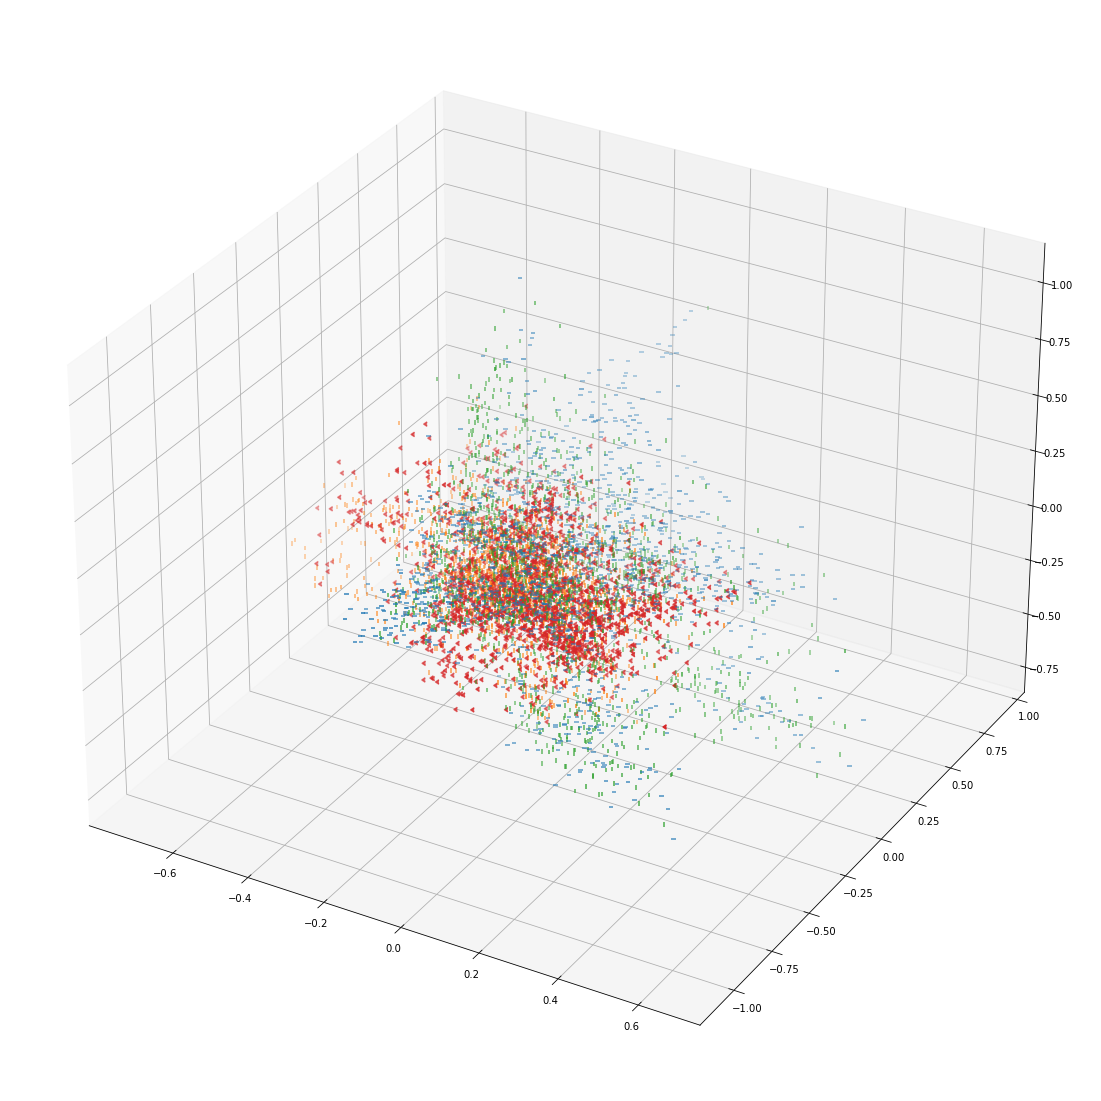

Epoch 1/10 successfull


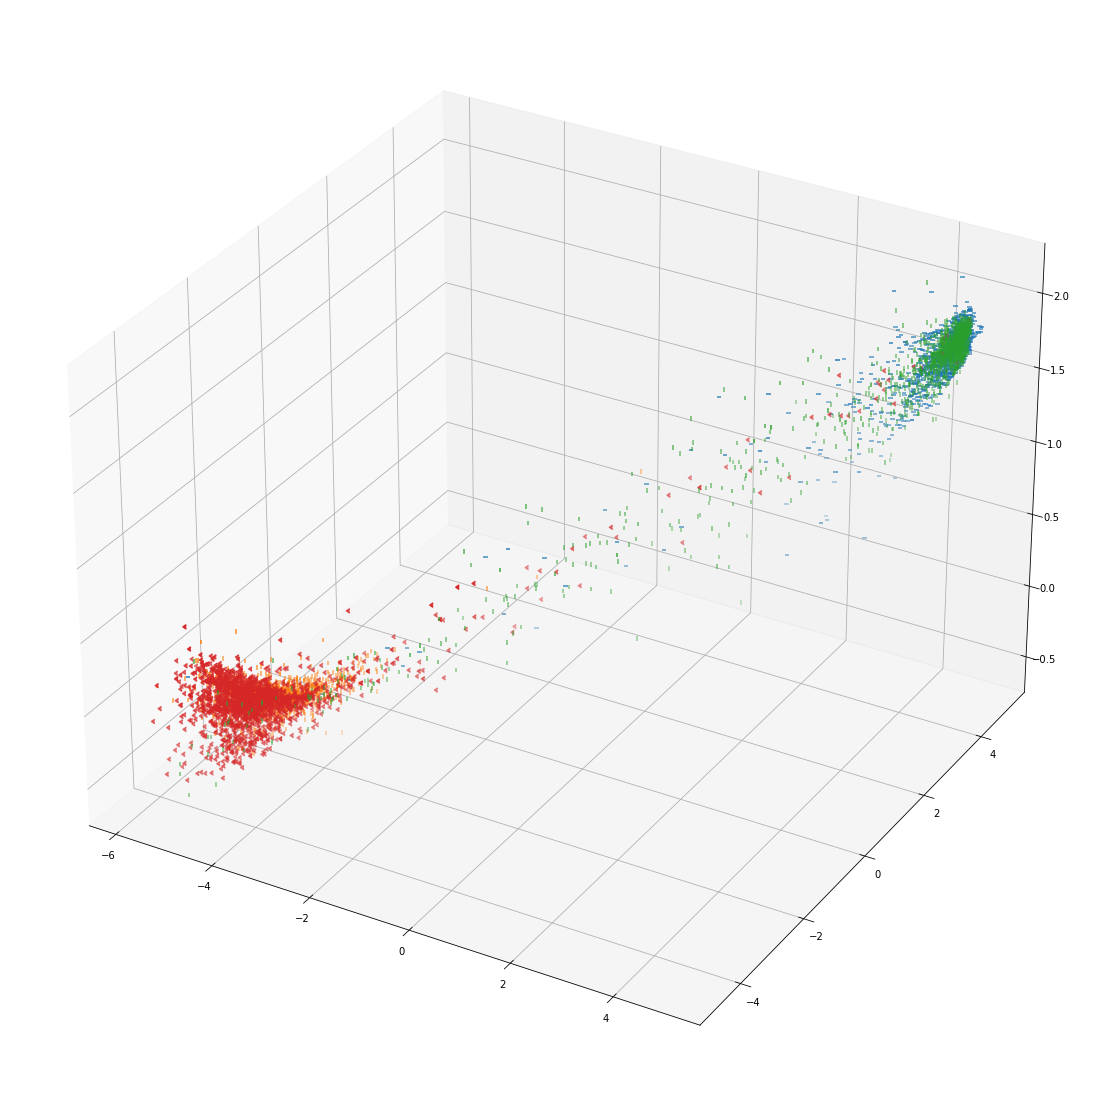

KeyboardInterrupt: 

In [12]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_train = SummaryWriter('runs/Dataloader2/train')
writer_val = SummaryWriter('runs/Dataloader2/val')
writer_test = SummaryWriter('runs/Dataloader2/test')
writer = {}
writer["train"] = writer_train
writer["val"] = writer_val
writer["test"] = writer_test


#define training params
num_epochs = 10
learning_rate = 0.1#0.008
GAMMA = 1  # 1000 more weight to transferability
SIGMA = [2,4,8]  # default 1

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss = MMD_loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


#dataloader for training and validation
dataloader_train = {}
dataloader_train["source"]=source_loader["train"]
dataloader_train["target"]=target_loader["test"]

#dataloader for testing
dataloader_val = {}
dataloader_val["source"]=source_loader["val"]
dataloader_val["target"]=target_loader["val"]

dataloaders = {}
dataloaders["train"] = dataloader_train
dataloaders["val"] = dataloader_val


#collect loss for each batch
loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
loss_list = {}
loss_list['train']=[]
loss_list['val']=[]
loss_list['test'] = []

mmd_loss_list = []
target_ce_loss_list = []

#collect accuracy for each batch
acc_total_source_collected = 0
acc_total_target_collected = 0
accuracy_list={}
accuracy_list['train']=[]
accuracy_list['val']=[]
accuracy_list['test']=[]



phases = ["val", "train"]
# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_out_collect = torch.empty((0,3))
    class_1_source_out_collect = torch.empty((0,3))
    class_0_target_out_collect = torch.empty((0,3))
    class_1_target_out_collect = torch.empty((0,3))
    
    loss_collected = 0
    acc_collected = 0
    

    
    for phase in phases:
        iter_loader_source = iter(dataloaders[phase]["source"])
        iter_loader_target = iter(dataloaders[phase]["target"])
        
        for i in range(len(dataloaders[phase]["source"])):

            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows

            batch_size = len(labels_source) #take length of shorter dataoader which is the one from source domain (reason:train, val split)
                        
            if phase == "val":
                
                model.train(False) #no training
                
                with torch.no_grad():
                    loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, GAMMA)
                    
                    loss_collected += loss
                    mmd_loss_collected += mmd_loss
                    target_ce_loss_collected += target_ce_loss
                    acc_total_source_collected += acc_total_source
                    acc_total_target_collected += acc_total_target
                    
                    # collect plot values
                    class_0_source_out_collect = torch.cat((class_0_source_out_collect, class_0_source_out), 0)
                    class_1_source_out_collect = torch.cat((class_1_source_out_collect, class_1_source_out), 0)
                    class_0_target_out_collect = torch.cat((class_0_target_out_collect, class_0_target_out), 0)
                    class_1_target_out_collect = torch.cat((class_1_target_out_collect, class_1_target_out), 0)
                    
                    
            
            elif phase == "train":
                
                model.train(True) # training
                
                                
                ########Forward pass########
                loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, GAMMA)
                
                loss_collected += loss
                mmd_loss_collected += mmd_loss
                target_ce_loss_collected += target_ce_loss
                acc_total_source_collected += acc_total_source
                acc_total_target_collected += acc_total_target

                ########Backward pass########
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==1 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_out_collect, class_1_source_out_collect, class_0_target_out_collect, class_1_target_out_collect]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i])
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}")       
                
                
    
        running_loss = loss_collected / len(dataloaders[phase]["source"])
        running_acc_source = acc_total_source_collected / len(dataloaders[phase]["source"])
        
        running_target_ce_loss = target_ce_loss_collected / len(dataloaders[phase]["source"])
        running_acc_target = acc_total_target_collected / len(dataloaders[phase]["source"])
        
        running_mmd_loss = mmd_loss_collected/ len(dataloaders[phase]["source"])
        
        loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
        
        #list of train and validation loss for later plot
        if phase == "train":
            loss_list[phase].append(running_loss.detach())
            
            #loss and accuracy 
            #plot
            accuracy_list['test'].append(running_acc_target)
            mmd_loss_list.append(running_mmd_loss.detach())
            target_ce_loss_list.append(running_target_ce_loss.detach())
            # tensorboard
            writer["test"].add_scalar(f'test_loss', running_target_ce_loss, epoch)
            writer["test"].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
            writer["test"].add_scalar(f'accuracy', running_acc_target, epoch)
            
        elif phase == "val":
            loss_list[phase].append(running_loss)
            
        #list of train and validation accuracy for later plot
        accuracy_list[phase].append(running_acc_source)
        
        #train and validation loss and accuracy tensorboard
        writer[phase].add_scalar(f'training loss', running_loss, epoch)
        writer[phase].add_scalar(f'accuracy', running_acc_source, epoch)



            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")




In [ ]:
fig1 = plt.figure()
plt.title('Loss')
plt.plot(loss_list['train'], 'bo-', label = 'train', linewidth=1,markersize=0.1)
plt.plot(loss_list['val'], 'ro-', label = 'val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('no_mmd_loss_source')



fig2 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list['train'], 'bo-', label = 'train', linewidth=1,markersize=0.1)
plt.plot(accuracy_list['val'], 'ro-', label = 'val', linewidth=1,markersize=0.1)
plt.plot(accuracy_list['test'], 'go-', label = 'test', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('no_mmd_accuracy_source')

fig3 = plt.figure()
plt.title('CE-Loss Target')
plt.plot(target_ce_loss_list, 'bo-', linewidth=1,markersize=0.1)
plt.show()
fig3.savefig('no_mmd_ce_loss_target')

fig4 = plt.figure()
plt.title('MMD Loss')
plt.plot(mmd_loss_list, 'bo-', linewidth=1,markersize=0.1)
plt.show()
fig4.savefig('no_mmd_mmd_loss')


In [41]:
with torch.no_grad():
    classes = ['class_0', 'class_1']
        
    #collect information about labels, predictions
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    n_class_samples_out = [0 for i in range(2)]
        
    #iterate through bateches in test_loader
    for i, (window, labels) in enumerate(target_loader["test"]):
        #make predictions for each batch
        outputs = model(window.float())
        outputs = classifier_layer_1(outputs)
        outputs = classifier_layer_2(outputs)
        outputs = classifier_layer_3(outputs)
        #for each element in batch check if prediction is correct and collect total and correct predictions and labels
        for i in range(len(labels)):
            label = labels[i]
            output = torch.argmax(outputs[i])
            print(output)
            if label == output:
                n_correct+=1
                n_class_correct[label]+=1
                    
            n_samples+=1
            n_class_samples[label]+=1
            n_class_samples_out[output]+=1
        else:
            break
        
    #calculate total accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
        
    #calculate class accuracy
    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %') 


tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
Accuracy of the network: 96.875 %
Accuracy of class_0: 94.5945945945946 %
Accuracy of class_1: 100.0 %


IndexError: list index out of range